In [348]:
import glob
import torch

from Bio import SeqIO
import re
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

embedding_dir='/Users/pamar/Desktop/projects/workshop_elixir/data'

def stack_res_tensors(tensors, embedding_dim=1280):
    # Prepare to stack tensors
    n_seqs = len(tensors)
    seq_max_length = max([t.shape[0] for t in tensors])
    # Initialize empty padded vector, with 0-padding for sequences with less than max length residues
    fill_tensor = torch.zeros(size=(n_seqs, seq_max_length, embedding_dim))

    # Load torch tensors from ESM embeddings matching sequence, fill padded tensor
    for i, tensor in enumerate(tensors):
        fill_tensor[i, 0:tensor.shape[0]] = tensor

    fill_tensor=torch.permute(fill_tensor, (0, 2, 1))

    return(fill_tensor)

def stack_labels(lists):
    # Prepare to stack tensors
    n_seqs = len(lists)
    seq_max_length = max([len(t) for t in tensors])
    # Initialize empty padded vector, with 0-padding for sequences with less than max length residues
    fill_tensor = torch.zeros((n_seqs, seq_max_length))
    mask_tensor = torch.zeros((n_seqs, seq_max_length))
    #fill_tensor=fill_tensor.long()
    # Load torch tensors from ESM embeddings matching sequence, fill padded tensor
    for i, tensor in enumerate(lists):
        fill_tensor[i, 0:len(tensor)] = torch.FloatTensor(tensor)
        mask_tensor[i, 0:len(tensor)] = torch.ones((1,len(tensor)))
        
    return(fill_tensor,mask_tensor)

def oneHot(seq):
    keys = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
    values = np.eye(20)
    one_hot_enc = dict(zip(keys, values))
    out=np.empty((0,20), int)
    for residue in seq:
        if (residue.upper() in one_hot_enc.keys()):
            out=np.vstack((out,one_hot_enc[residue.upper()]))
        else:
            out=np.vstack((out,np.zeros(1,20)))
    return(out)
    

tensors = []
labels=[]

for record in SeqIO.parse("../data/bepipred3_50ID.fasta", "fasta"):
    file=embedding_dir+"/"+record.id+".pt"
    tensor = torch.load(file)
    tensor1=torch.from_numpy(oneHot(record.seq))
    tensor1=torch.cat([tensor1,tensor],dim=1)
    tensors.append(tensor1)
    y=[1 if x.isupper() else 0 for x in record.seq]
    labels.append(y)


stacked_tensor = stack_res_tensors(tensors,50)
stacked_labels, stacked_mask = stack_labels(labels)





In [349]:
from torch.utils.data import Dataset

class EpitopeDataset(Dataset):
    def __init__(self,embeddings,labels,mask,batch=4):
        self.embeddings = embeddings
        self.labels = labels
        self.mask = mask

    def __len__(self):
        return (self.embeddings).shape[0]

    def __getitem__(self,idx):
        return self.embeddings[idx] , self.labels[idx], self.mask[idx]

dataset= EpitopeDataset(stacked_tensor[0:-20],stacked_labels[0:-20], stacked_mask[0:-20])
validation= EpitopeDataset(stacked_tensor[-20:],stacked_labels[-20:],stacked_mask[-20:])



In [350]:
type(stacked_tensor)

torch.Tensor

In [351]:
import torch.optim as optim
import torch.nn as nn
import sklearn
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
slice_start=0
slice_end=50


class Simple1DCNN(torch.nn.Module):
    def __init__(self):
        super(Simple1DCNN, self).__init__()
        self.layer1 = torch.nn.Conv1d(in_channels=slice_end-slice_start, out_channels=20, kernel_size=5, stride=1,padding='same')
        self.act1 = torch.nn.ReLU()
        self.layer2 = torch.nn.Conv1d(in_channels=20, out_channels=100, kernel_size=3,padding='same')
        self.layer3 = torch.nn.Linear( in_features=100, out_features=1)
        self.drop = nn.Dropout(p=0.1)
        self.act2 = nn.Sigmoid()

    def forward(self, x):
        x = x[:,slice_start:slice_end,:]
        x = self.layer1(x)
        x = self.drop(x)
        x = self.act1(x)
        x = self.layer2(x)
        x = self.drop(x)
        x = self.act1(x)
        x = torch.permute(x,(0,2,1))
        x = self.layer3(x)
        x = self.act2(x)

        return x

net = Simple1DCNN()

In [352]:


criterion= nn.BCELoss(reduction='none')


#def criterion(output,labels):
    
    
    
    
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.2, weight_decay=0.1)
#scheduler = optim.ExponentialLR(optimizer, gamma=0.9)

trainloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)
validloader = torch.utils.data.DataLoader(validation, batch_size=1)


In [353]:
def xxx():
    valid_loss=0
    train_loss=0
    net.eval()
    inputs, labels, mask = dataset[:]
    outputs = net(inputs)
    loss = criterion(torch.squeeze(outputs), labels)
    loss=loss*mask
    loss=torch.sum(loss)/torch.sum(mask)
    training_plot.append(loss)
    #labels, outputs= get_labels_preds_and_posprob_without_padding( outputs,labels.flatten() )
    auc_train_plot.append(roc_auc_score(labels[mask>0], outputs.squeeze()[mask>0]))
    mcc_train_plot.append(matthews_corrcoef(labels[mask>0], outputs.squeeze()[mask>0]>.1))

    inputs, labels, mask = validation[:]
    outputs = net(inputs)
    loss = criterion(torch.squeeze(outputs), labels)
    loss=loss*mask
    loss=torch.sum(loss)/torch.sum(mask)
    validation_plot.append(loss)
    #labels, outputs= get_labels_preds_and_posprob_without_padding( outputs,labels.flatten() )
    auc_valid_plot.append(roc_auc_score(labels[mask>0], outputs.squeeze()[mask>0]))
    mcc_valid_plot.append(matthews_corrcoef(labels[mask>0], outputs.squeeze()[mask>0]>.1))

In [354]:
def weight_reset(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        m.reset_parameters()


net.apply(weight_reset)
losses=[]
training_plot=[]
validation_plot=[]
auc_train_plot=[]
auc_valid_plot=[]
mcc_train_plot=[]
mcc_valid_plot=[]

last_score=np.inf
max_es_rounds = 15
es_rounds = max_es_rounds
best_epoch= 0

# print statistics
with torch.no_grad():
    valid_loss=0
    train_loss=0
    net.eval()
    inputs, labels, mask = dataset[:]
    outputs = net(inputs)
    loss = criterion(torch.squeeze(outputs), labels)
    loss=loss*mask
    loss=torch.sum(loss)/torch.sum(mask)
    training_plot.append(loss)
    #labels, outputs= get_labels_preds_and_posprob_without_padding( outputs,labels.flatten() )
    auc_train_plot.append(roc_auc_score(labels[mask>0], outputs.squeeze()[mask>0]))
    mcc_train_plot.append(matthews_corrcoef(labels[mask>0], outputs.squeeze()[mask>0]>.1))

    inputs, labels, mask = validation[:]
    outputs = net(inputs)
    loss = criterion(torch.squeeze(outputs), labels)
    loss=loss*mask
    loss=torch.sum(loss)/torch.sum(mask)
    validation_plot.append(loss)
    #labels, outputs= get_labels_preds_and_posprob_without_padding( outputs,labels.flatten() )
    auc_valid_plot.append(roc_auc_score(labels[mask>0], outputs.squeeze()[mask>0]))
    mcc_valid_plot.append(matthews_corrcoef(labels[mask>0], outputs.squeeze()[mask>0]>.1))
    print("Epoch 0, training loss {}, validation loss {}".format( training_plot[-1], validation_plot[-1]))
    print("Epoch 0, training MCC {}, validation MCC {}".format( mcc_train_plot[-1], mcc_valid_plot[-1]))





for epoch in range(50):  # loop over the dataset multiple times
    net.train()
   
    for i, data in enumerate(trainloader,0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, mask = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        #scheduler.step()     
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(torch.squeeze(outputs), labels)
        #loss=loss*mask
        loss=torch.sum(loss)/torch.sum(mask)
   
        loss.backward()
        optimizer.step()
    
# print statistics
    with torch.no_grad():
        valid_loss=0
        train_loss=0
        net.eval()
        inputs, labels, mask = dataset[:]
        outputs = net(inputs)
        loss = criterion(torch.squeeze(outputs), labels)
        loss=loss*mask
        loss=torch.sum(loss)/torch.sum(mask)
        training_plot.append(loss)
        auc_train_plot.append(roc_auc_score(labels[mask>0], outputs.squeeze()[mask>0]))
        mcc_train_plot.append(matthews_corrcoef(labels[mask>0], outputs.squeeze()[mask>0]>.1))
    
 

        inputs, labels, mask = validation[:]
        outputs = net(inputs)
        loss = criterion(torch.squeeze(outputs), labels)
        loss=loss*mask
        loss=torch.sum(loss)/torch.sum(mask)       
        validation_plot.append(loss)
        #labels, outputs= get_labels_preds_and_posprob_without_padding( outputs.flatten(),labels.flatten() )
        auc_valid_plot.append(roc_auc_score(labels[mask>0], outputs.squeeze()[mask>0]))
        mcc_valid_plot.append(matthews_corrcoef(labels[mask>0], outputs.squeeze()[mask>0]>.1))
        print("Epoch {}, training loss {}, validation loss {}".format(epoch, training_plot[-1], validation_plot[-1]))
        print("Epoch {}, training MCC {}, validation MCC {}".format(epoch, mcc_train_plot[-1], mcc_valid_plot[-1]))

    

        
        
    if last_score > loss:
        last_score = loss
        best_epoch = epoch
        es_rounds = max_es_rounds
    else:
        if es_rounds > 0:
            es_rounds -=1
        else:
            print('EARLY-STOPPING !')
            print('Best epoch found: nº {}'.format(best_epoch))
            print('Exiting. . .')
            break




Epoch 0, training loss 0.5869105458259583, validation loss 0.5901013016700745
Epoch 0, training MCC 0.0, validation MCC 0.0
Epoch 0, training loss 0.3943992853164673, validation loss 0.429705947637558
Epoch 0, training MCC 0.0, validation MCC 0.0
Epoch 1, training loss 0.3858840763568878, validation loss 0.43227508664131165
Epoch 1, training MCC 0.03161161215269915, validation MCC 0.005868386436849848
Epoch 2, training loss 0.385549396276474, validation loss 0.4338337779045105
Epoch 2, training MCC 0.04927561523082036, validation MCC 0.04455817703490435
Epoch 3, training loss 0.38536933064460754, validation loss 0.4349316358566284
Epoch 3, training MCC 0.06956780578261154, validation MCC 0.08271689589886527
Epoch 4, training loss 0.3846362829208374, validation loss 0.4341108202934265
Epoch 4, training MCC 0.07053749178283572, validation MCC 0.07536520731260045
Epoch 5, training loss 0.38411247730255127, validation loss 0.43399959802627563
Epoch 5, training MCC 0.07700836338299794, vali

In [355]:
type(labels)

torch.Tensor

In [356]:
loss.shape

torch.Size([])

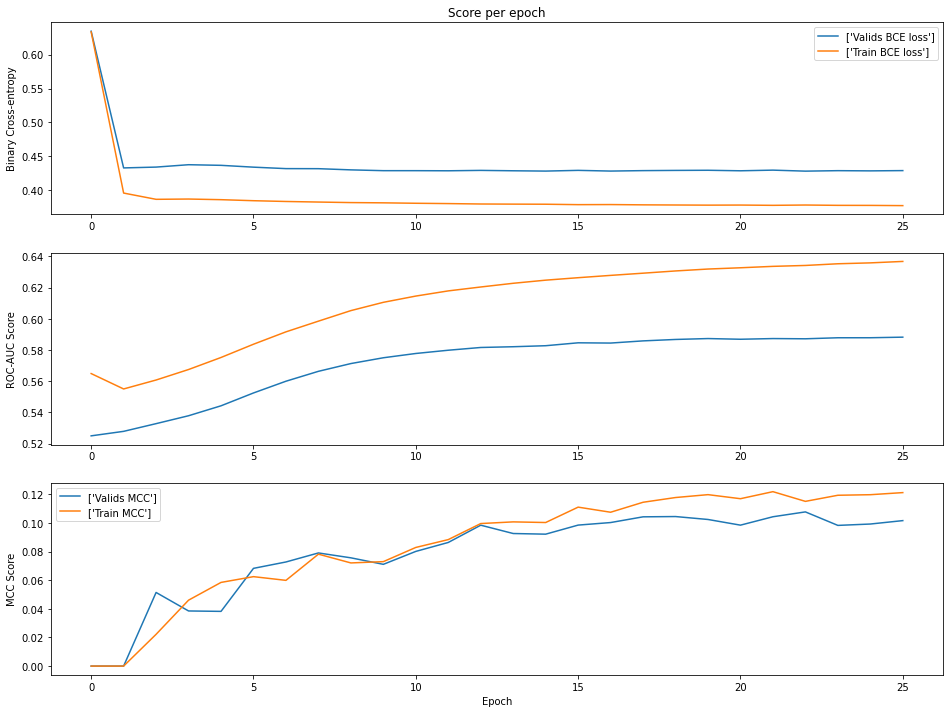

In [347]:
plt.figure(figsize=(16,12))
plt.subplot(3, 1, 1)
plt.title('Score per epoch')
plt.ylabel('Binary Cross-entropy')
# plt.plot(list(range(len(losses))), [x[0] for x in losses], label=['Trains BCE loss'])
plt.plot(list(range(len(training_plot))), validation_plot, label=['Valids BCE loss'])
plt.plot(list(range(len(training_plot))), training_plot, label=['Train BCE loss'])

plt.legend()
plt.subplot(3, 1, 2)
plt.ylabel('ROC-AUC Score')
# plt.plot(list(range(len(losses))), [x[2] for x in losses], label=['Trains ROC_AUC'])
plt.plot(list(range(len(training_plot))), auc_valid_plot, label=['Valids ROC_AUC'])
plt.plot(list(range(len(training_plot))), auc_train_plot, label=['Train ROC_AUC'])

plt.subplot(3, 1, 3)
plt.ylabel('MCC Score')
# plt.plot(list(range(len(losses))), [x[2] for x in losses], label=['Trains ROC_AUC'])
plt.plot(list(range(len(training_plot))), mcc_valid_plot, label=['Valids MCC'])
plt.plot(list(range(len(training_plot))), mcc_train_plot, label=['Train MCC'])

plt.xlabel('Epoch')


plt.legend()
plt.legend()
plt.show()
     